# Demo

[...]

In [1]:
import ducc0

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
from beamconv import ScanStrategy
import qpoint as qp
import copy

cmap_viridis = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap_magma = copy.copy(matplotlib.cm.get_cmap("magma"))

import warnings
warnings.filterwarnings("ignore")

The Cls coefficients are read from an input file. By working with healpy, the T, Q and U maps are then evaluated and plotted.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


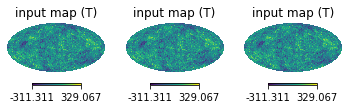

In [2]:
# reading cls from .txt file
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',unpack=True)
ell, cls = cls[0], cls[1:]

# calculating alm from cls
lmax=128
np.random.seed(25)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True)

# calculating map0 from alm
map0 = hp.alm2map(alm, 512)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.axes(ax1)
hp.mollview(map0[0],title='input map (T)', hold=True, cmap=cmap_viridis)
plt.axes(ax2)
hp.mollview(map0[0],title='input map (T)', hold=True, cmap=cmap_viridis)
plt.axes(ax3)
hp.mollview(map0[0],title='input map (T)', hold=True, cmap=cmap_viridis)
plt.show()

### Setting up beamconv
Together with the input maps, we need to specify a scanning strategy and the focal plane specifics. Provided with that, beamconv is able to produce the TODs.

In [3]:
# Setting up the scanning strategy
ctime0 = 1510000000            # Initial time
mlen = 1 * 24 * 60 * 60        # Mission length in seconds (one day!)

mmax = 2                       # WHAT'S THIS?
nside_spin = 128               # WHAT'S THIS?
preview_pointing = False
verbose = True

# Definition of the scannin strategy making use of LiteBIRD's specifics
ss = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,
        theta_boresight = 50.,
        freq_antisun = 192.348, 
        freq_boresight = 0.314, 
        sample_rate = 19.1,
        jitter_amp=0.0,
        location='space',
        ctime0=ctime0)

ss_hwp = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,
        theta_boresight = 50.,
        freq_antisun = 192.348, 
        freq_boresight = 0.314, 
        sample_rate = 19.1,
        jitter_amp=0.0,
        location='space',
        ctime0=ctime0)

# Further options
scan_opts = dict(
        q_bore_func=ss.litebird_scan,
        ctime_func=ss.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=mmax,
        nside_spin=nside_spin,
        preview_pointing=preview_pointing,
        verbose=verbose,
        save_tod=True)

Why if I re-run the cell below it scans with 4 detectors?

In [4]:
# Create a grid of Gaussian beams
nrow = 3
ncol = 3
ndet = nrow * ncol

# Setting up the beam options
beam_opts = dict(lmax=lmax,
                 fwhm=40,          # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian',
                 no_pairs=True)    # Single detector for each beam (instead of a pair)

# Creating the focal plane
ss.create_focal_plane(nrow=nrow, ncol=ncol, fov=3, **beam_opts)
ss_hwp.create_focal_plane(nrow=nrow, ncol=ncol, fov=3, **beam_opts)

In [9]:
# Calculate TODs in ten chunks
chunks = ss.partition_mission(0.1 * ss.mlen * ss.fsamp)
chunks_hwp = ss_hwp.partition_mission(0.1 * ss.mlen * ss.fsamp)

# Producing the coverage map
ss.allocate_maps(nside=128)
ss.scan_instrument_mpi(alm, **scan_opts)
maps, cond, proj = ss.solve_for_map(return_proj = True)

ss_hwp.set_hwp_mod(mode='continuous', freq=88*2*np.pi/60)

ss_hwp.allocate_maps(nside=128)
ss_hwp.scan_instrument_mpi(alm, **scan_opts)
maps, cond, proj_hwp = ss_hwp.solve_for_map(return_proj = True)

Scanning with 18 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-165024
Implementing litebird scan
[rank 000]:	Working on chunk 001: samples 165024-330048
Implementing litebird scan
[rank 000]:	Working on chunk 002: samples 330048-495072
Implementing litebird scan
[rank 000]:	Working on chunk 003: samples 495072-660096
Implementing litebird scan
[rank 000]:	Working on chunk 004: samples 660096-825120
Implementing litebird scan
[rank 000]:	Working on chunk 005: samples 825120-990144
Implementing litebird scan
[rank 000]:	Working on chunk 006: samples 990144-1155168
Implementing litebird scan
[rank 000]:	Working on chunk 007: samples 1155168-1320192
Implementing litebird scan
[rank 000]:	Working on chunk 008: samples 1320192-1485216
Implementing litebird scan
[rank 000]:	Working on chunk 009: samples 1485216-1650240
Implementing litebird scan
[rank 000]: working on: r001c000A, r001c000B
[rank 000]:	Working on chunk 000: samples 0-165024


[rank 000]:	Working on chunk 003: samples 495072-660096
Implementing litebird scan
[rank 000]:	Working on chunk 004: samples 660096-825120
Implementing litebird scan
[rank 000]:	Working on chunk 005: samples 825120-990144
Implementing litebird scan
[rank 000]:	Working on chunk 006: samples 990144-1155168
Implementing litebird scan
[rank 000]:	Working on chunk 007: samples 1155168-1320192
Implementing litebird scan
[rank 000]:	Working on chunk 008: samples 1320192-1485216
Implementing litebird scan
[rank 000]:	Working on chunk 009: samples 1485216-1650240
Implementing litebird scan
[rank 000]: working on: r001c000A, r001c000B
[rank 000]:	Working on chunk 000: samples 0-165024
Implementing litebird scan
[rank 000]:	Working on chunk 001: samples 165024-330048
Implementing litebird scan
[rank 000]:	Working on chunk 002: samples 330048-495072
Implementing litebird scan
[rank 000]:	Working on chunk 003: samples 495072-660096
Implementing litebird scan
[rank 000]:	Working on chunk 004: sample

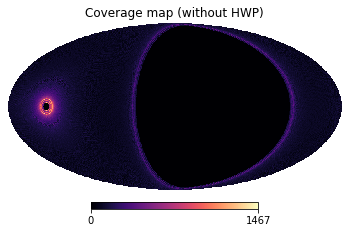

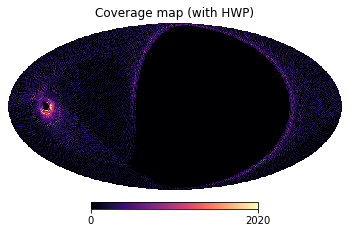

In [12]:
hp.mollview(proj[0],title='Coverage map (without HWP)', hold=True, cmap=cmap_magma)
plt.show()

hp.mollview(proj_hwp[0],title='Coverage map (with HWP)', hold=True, cmap=cmap_magma)
plt.show()

In [13]:
# Parameters for generating noise with ducc0
sigma = 10
f_min=1e-4
f_knee=1e-1
f_samp=19.1
slope=-1.7
nsamp = int(0.1 * ss.mlen * ss.fsamp)

# Setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD = np.empty((ndet,int(ss.mlen*ss.fsamp)))
noisy_TOD = np.empty((ndet,int(ss.mlen*ss.fsamp)))
noise_TOD = np.empty((ndet,int(ss.mlen*ss.fsamp)))

# Setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD_hwp = np.empty((ndet,int(ss.mlen*ss.fsamp)))
noisy_TOD_hwp = np.empty((ndet,int(ss.mlen*ss.fsamp)))
noise_TOD_hwp = np.empty((ndet,int(ss.mlen*ss.fsamp)))

[...]

In [14]:
for det in np.arange(ndet):
    gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)
    for chunk in np.arange(10):
        inp = np.random.normal(0.,1.,(nsamp,))
        noise = gen.filterGaussian(inp)
        #
        clean_data = ss.data(chunks[chunk],ss.beams[det][0],data_type='tod')
        noisy_data = clean_data + noise
        clean_TOD[det,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = clean_data
        noisy_TOD[det,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = noisy_data
        noise_TOD[det,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = noise
        #
        clean_data = ss_hwp.data(chunks_hwp[chunk],ss.beams[det][0],data_type='tod')
        noisy_data = clean_data + noise
        clean_TOD_hwp[det,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = clean_data
        noisy_TOD_hwp[det,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = noisy_data
        noise_TOD_hwp[det,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = noise

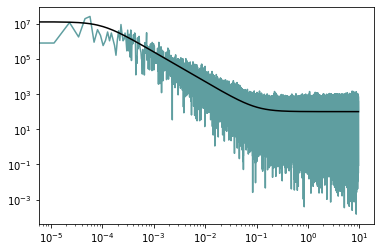

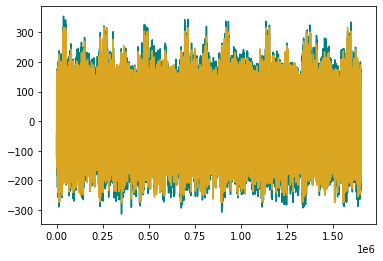

In [15]:
# evaluating power spectrum
ps = np.abs(np.fft.fft(noise_TOD[0,:]))**2 / (nsamp*10)
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD[0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

# plotting
#plt.plot(freqs[idx], ps[idx])
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'cadetblue')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'black')
plt.show()

plt.plot(noisy_TOD[0,:],'teal')
plt.plot(clean_TOD[0,:],'goldenrod')
plt.show()

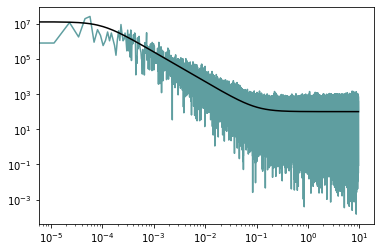

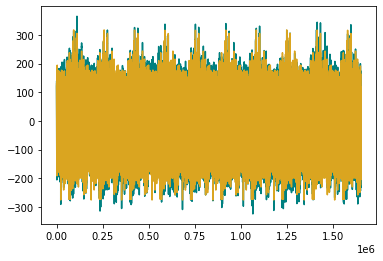

In [16]:
# evaluating power spectrum
ps = np.abs(np.fft.fft(noise_TOD[0,:]))**2 / (nsamp*10)
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD[0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

# plotting
#plt.plot(freqs[idx], ps[idx])
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'cadetblue')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'black')
plt.show()

plt.plot(noisy_TOD_hwp[0,:],'teal')
plt.plot(clean_TOD_hwp[0,:],'goldenrod')
plt.show()

In [17]:
print(clean_TOD-clean_TOD_hwp)

[[-1.67038570e+02 -1.82963708e+02 -1.82896428e+02 ...  1.44077405e+00
   1.93093498e+00  1.89769732e+00]
 [-2.02443698e+02 -2.02612518e+02 -2.02727607e+02 ...  8.30514727e-01
   1.02437844e+00  1.08733175e+00]
 [-1.62822765e+02 -1.62704761e+02 -1.63469650e+02 ... -1.81221707e-02
   1.24229758e-01  3.13650088e-01]
 ...
 [-2.75536320e+01 -2.76405273e+01 -2.77771536e+01 ...  9.75155558e-01
   1.48044898e+00  1.56436752e+00]
 [-7.93242491e+01 -7.90236052e+01 -7.87652356e+01 ...  8.46096627e-01
   1.13714722e+00  1.32160396e+00]
 [-1.09446420e+02 -1.09670565e+02 -1.22463956e+02 ... -2.35753574e-01
  -4.05832075e-01 -5.72631342e-01]]
